# Exploration of NHL Player Statistics by Birth Month
> Work in progress post about the kinds of careers NHL player tend to have based on their birth month

- comments: true

In [1]:
#hide
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from numpy import number
from bokeh.models import ColumnDataSource, HBar, Segment, Rect, Select, CustomJS, DataTable, TableColumn, RadioButtonGroup
from bokeh.layouts import layout, column, row
from bokeh.palettes import Colorblind
from datetime import datetime
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from IPython.core.display import display, HTML

In [5]:
#hide

def returnGrouping(month):
    early = ['January', 'February', 'March']
    earlyMid = ['April', 'May', 'June']
    lateMid = ['July', 'August', 'September']
    late = ['October', 'November', 'December']
    if month in early:
        return 'Early'
    elif month in earlyMid:
        return 'Early Middle'
    elif month in lateMid:
        return 'Late Middle'
    elif month in late:
        return 'Late'
    return 'None'

players_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\person.csv")
players_df['birth_date'] = pd.to_datetime(players_df['birth_date'], format="%Y-%m-%d %H:%M:%S-%f")
players_df['birth_month_number'] = players_df['birth_date'].dt.month
players_df['birth month'] = players_df['birth_date'].dt.month_name()
players_df['Year Grouping'] = players_df['birth month'].apply(returnGrouping)
players_df = players_df.sort_values(by='birth_month_number')

roster_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\roster.csv")
teams_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\teams.csv")
nhl_stats_df = pd.read_csv(r"C:\Users\jacks\Development\Python\jcrs-blog\_notebooks\playerStats.csv")
nhl_stats_df = nhl_stats_df[(nhl_stats_df['league_id'] == 133) & (nhl_stats_df['games'] > 9)]

reduced_stats_df = nhl_stats_df[[
    'person_id',
    'assists',
    'goals',
    'pim',
    'shots',
    'games',
    'hits',
    'power_play_goals',
    'power_play_assists',
    'blocked_shots',
    'shifts',
]]
career_stats_df = pd.DataFrame(reduced_stats_df.groupby(by='person_id', sort=False).sum())
birth_months_df = players_df[['person_id', 'Year Grouping', 'birth_month_number']]
career_stats_df = pd.merge(left=career_stats_df, right=birth_months_df, on='person_id')
career_stats_df = career_stats_df.sort_values(by='birth_month_number')
career_stats_df = career_stats_df[[
    'Year Grouping',
    'assists',
    'goals',
    'pim',
    'shots',
    'games',
    'hits',
    'power_play_goals',
    'power_play_assists',
    'blocked_shots',
    'shifts',]]
rename_map = {'power_play_goals': 'power play goals', 
              'power_play_assists': 'power play assists',
              'blocked_shots': 'blocked shots',
}
career_stats_df = career_stats_df.rename(columns=rename_map)
df = career_stats_df
career_stats_df['points'] = df['goals'] + df['assists']
career_stats_df['power play points'] = df['power play goals'] + df['power play assists'] 
career_stats_df['shooting percentage'] = df['goals'] / df['shots'] * 100

career_stats_by_game_df = pd.DataFrame()
career_stats_by_game_df['Year Grouping'] = career_stats_df['Year Grouping']
career_stats_by_game_df['assists'] = career_stats_df['assists'] / career_stats_df['games']
career_stats_by_game_df['goals'] = career_stats_df['goals'] / career_stats_df['games']
career_stats_by_game_df['points'] = career_stats_df['points'] / career_stats_df['games']
career_stats_by_game_df['pim'] = career_stats_df['pim'] / career_stats_df['games']
career_stats_by_game_df['shots'] = career_stats_df['shots'] / career_stats_df['games']
career_stats_by_game_df['hits'] = career_stats_df['hits'] / career_stats_df['games']
career_stats_by_game_df['power play goals'] = career_stats_df['power play goals'] / career_stats_df['games']
career_stats_by_game_df['power play assists'] = career_stats_df['power play assists'] / career_stats_df['games']
career_stats_by_game_df['power play points'] = career_stats_df['power play points'] / career_stats_df['games']
career_stats_by_game_df['blocked shots'] = career_stats_df['blocked shots'] / career_stats_df['games']
career_stats_by_game_df['shifts'] = career_stats_df['shifts'] / career_stats_df['games']

# grouping by Year Grouping for year grouping seaborn histogram
yearly_grouping_df = pd.DataFrame(career_stats_df['Year Grouping'].value_counts(sort=False))
yearly_grouping_percents_df = pd.DataFrame(career_stats_df['Year Grouping'].value_counts(sort=False, normalize=True))
yearly_grouping_df['Percent'] = yearly_grouping_percents_df['Year Grouping'] * 100
yearly_grouping_df['Percent'] = yearly_grouping_df['Percent'].round(1)

In Malcolm Gladwell's book 'Outliers', which coined the now pervasive ten thousand hour rule, he discusses an interesting trend in professional hockey. Players who make it to the upper echelons of the hockey world tend be born in the earlier months of the year. The chapter wherein Gladwell discusses this is phenomenon is based on the work of a group of canadian phsycologists (R.H. Barnsley, A.H. Thompson, and P.E. Barnsley) who published their paper 'Hockey Success and Relative Birthdate: The Relative Age Effect' in 1985. At the time they found that 32.0% of hockey players in the National Hockey League (NHL) where born in the months of January, February, and March. In contrast, only 16.2% where born in the months of October, November, and December.  Their findings for the Ontario Hockey League (OHL) and the Western Hockey League (WHL) where very similar. They conclude that this was likely the result of how players are grouped in minor hockey leagues. In Canada you're placed into your division based on your age on December 31st. This means that players born in the early months of the year have the advantage of being the oldest players in their groupings. They will be bigger, stronger, faster, and more mentally developed than the players they are competing against. Thats a significant advantage in a game like hockey.

But this trend was observed in 1985. Does it still hold true for todays players? Taking it further than that, does the month a player is born have an effect on what their career looks like as a professional hockey player? Are players born in September more likely to become goal scoring phenoms like Alex Ovechkin (born september 17th)? What about January born players, are they likely to become point scoring superstars like Connor McDavid (born January 13th)? While both those players almost certainly qualify as outliers, is it possible that this trend extends further than just the pool of players playing the game, but to the actual performance on the ice as well? Is there a pronounced difference in the stats of players in the early months of the year when compared to the later months of the year? 

Luckily, the NHL provides easy access to the data required to investigate this through its open API. Using it I created a dataset that includes any players who has played more than 9 games in one season since the NHL lockout in 2005. With that dataset and some Python its easy enough to see that the trend still holds up today:

Just as observed in 1985, there are substantially more players whose birthdays fall closer to the beginning of the calendar year than the end. Being born in February looks to give you the best chance to make the NHL with 331 players born that month. In opposition, November registers by far the lowest with just 173 players. A better way to visualize this is perhaps to pool the players into 4 categories based on the time of year they are born. Lets take a look with four categories, Early (January, February, March), Early Middle (April, May, June), Late Middle (July, August, September), and Late (October, November, December) similar to how they looked in the original paper.

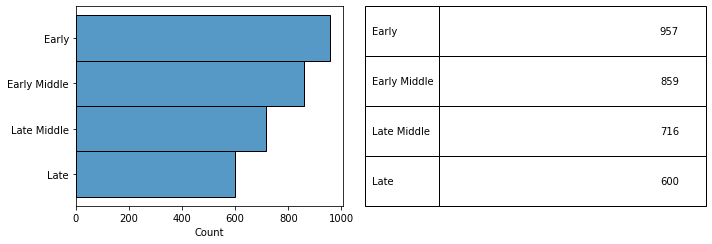

In [120]:
#hide_input
plt.rcParams["figure.autolayout"] = True

fig = plt.figure(figsize=(10,3.5))

ax1 = fig.add_subplot(122)
ax1.axis('off')
mpl_table = ax1.table(cellText =yearly_grouping_df.values, bbox=bbox, rowLabels=yearly_grouping_df.index)

ax2 = fig.add_subplot(121)
hist = sb.histplot(y='Year Grouping', data=players_df, ax=ax2)
hist.set(ylabel=None)

plt.show()


There are 957 players born in the 'Early' grouping months, while there are only 600 players born in the 'Late' grouping. That means that 30.6% of players fall into 'Early' and 19.2% are categorized as 'Late'. That is very close to the 32.9% to 16.2% found by Barnsley et al. in 1985. It means that for every 10 players born in the months of October, November, or December who make the NHL there are roughly 16 making it born in the months of January, February, or March. This is just a visualization and its not attempting to prove statistically significance, but those numbers certainly suggest a very pronounced correlation. 

So given that the trend certainly looks to be holding in todays NHL, lets explore a little deeper. Below is a boxplot without outliers (https://en.wikipedia.org/wiki/Box_plot). Outliers marks are left off because while its interesting to see just how much Alex Ovechkin has dominated goal scoring the past 20 years, its not the goal here. The goal instead is to get a high level view of the career statistics of NHL players based on the month they where born.

In [6]:
#hide

output_notebook()
x_value = 'assists'
y_value = 'Year Grouping'

categories = career_stats_df[y_value].unique().tolist()
options = ['Total', 'By Game']

# if lower bound is less than zero, zero it
def greaterThanZero(x):
    return x if (x > 0) else 0

selections = ColumnDataSource(data = dict(selected=['assists'], by=[0]))
sources = {}
data_sources = { 0: {}, 1: {}};
select = 0;
x_axis_values = career_stats_df.select_dtypes([number]).columns

def calculate_quantiles(x, y, source_dataframe): 
    df = source_dataframe[[
        y, 
        x, 
    ]]
    groups = df.groupby(y)
    q1 = groups.quantile(q=0.25).reindex(categories)
    q2 = groups.quantile(q=0.5).reindex(categories)
    q3 = groups.quantile(q=0.75).reindex(categories)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    lower[x] = lower[x].apply(greaterThanZero)
    
    source_dict = {
        'y': categories,
        'lower': lower[x],
        'q1': q1[x],
        'q2': q2[x],
        'q3': q3[x],
        'upper': upper[x]
    }
    return source_dict

for x_axis_value in x_axis_values: 
    total_dict = calculate_quantiles(x_axis_value, y_value, career_stats_df)
    data_sources[0][x_axis_value] = total_dict
    if (x_axis_value not in ['games', 'shooting percentage']):
        per_game_dict = calculate_quantiles(x_axis_value, y_value, career_stats_by_game_df)
        data_sources[1][x_axis_value] = per_game_dict  
    
tooltips = """
<div>
    <span style="font-size: 12px; font-weight: bold;">@y</span>&nbsp;
</div>
<div>
    <span style="font-size: 10px;">Lower bounds: @lower</span><br>
    <span style="font-size: 10px;">First quartile: @q1</span><br>
    <span style="font-size: 10px;">Median: @q2</span><br>
    <span style="font-size: 10px;">Third quartile: @q3</span><br>
    <span style="font-size: 10px;">Upper bounds: @upper</span>
</div>
"""
p = figure(y_range=categories, tooltips=tooltips, aspect_ratio=1.5)

source = ColumnDataSource(data=data_sources[0][x_value])

hbar = HBar(
        y='y', 
        height=0.6,
        left='q1',
        right='q3',
        fill_color = Colorblind[8][0]
)

lower_segment = Segment(x0='lower', y0='y', x1='q1' ,y1='y')
upper_segment = Segment(x0='q3', y0='y', x1='upper' ,y1='y')
lower_rect = Rect(x='lower', y='y', width=0.001, height=0.8)
middle_rect = Rect(x='q2', y='y', width=0.001, height=0.8)
upper_rect = Rect(x='upper', y='y', width=0.001, height=0.8)

p.add_glyph(source, hbar)
p.add_glyph(source, lower_segment)
p.add_glyph(source, upper_segment)
p.add_glyph(source, lower_rect)
p.add_glyph(source, middle_rect)
p.add_glyph(source, upper_rect)

x_select = Select(options=x_axis_values.tolist(), value=x_value)
x_select.js_on_change("value", CustomJS(args=dict(source=source, data_sources=data_sources, selections=selections), 
code="""
    selections.data = {'selected': [this.value], 'by': [selections.data.by]};
    selections.change.emit();
    const new_data = data_sources[selections.data.by][this.value]
    source.data = new_data;
    source.change.emit();
"""))
breakout_radio = RadioButtonGroup(labels=options, active=0)
breakout_radio.js_on_click(CustomJS(args=dict(source=source, data_sources=data_sources, selections=selections), code="""
    selections.data = {'selected': [selections.data.selected], 'by': [this.active]};
    selections.change.emit();
    const new_data = data_sources[this.active][selections.data.selected[0]]
    source.data = new_data;
    source.change.emit();
    console.log(new_data)
"""))

columns = [
    TableColumn(field='y', title='Grouping'),
    TableColumn(field="lower", title='0th Percentile'),
    TableColumn(field="q1", title='25th Percentile'),
    TableColumn(field="q2", title='50th Percentile'),
    TableColumn(field="q3", title='75th Percentile'),
    TableColumn(field="upper", title='100th Percentile'),
]
table = DataTable(source=source, columns=columns, index_position=None, aspect_ratio=3)

layout = column(row(x_select,breakout_radio), p, table)

output_file('overall_boxplot.html')
# show the results
show(layout)

Loading BokehJS ...

In [7]:
#hide_input
display(HTML('./boxplot.html'))